# DREAM - Tutorial on simulated data

In this tutorial, we will demonstrate how to generate Relational Event Model (REM) data sequences and how to apply the Deep Relational Event Additive Model (DREAM) on this data. This script was initially executed on Google Colab with a basic account.

To begin, it's helpful to know the capabilities of the hardware in use. By executing the `!nvidia-smi` command, you can retrieve essential details about the GPU currently in use. For those utilizing a subscription-free account on Google Colab, you'll likely be allocated a `Tesla T4` GPU. This GPU comes equipped with more than 15GB of memory, providing more than enough computational power for this deep learning task.

In [1]:
!nvidia-smi

Tue Apr  9 14:37:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import torch

### Import data generation scripts ###
from data_generation.rem_generation import *

### Import model scripts ###
from model.dream import DREAM #basic dream function
from model.dream_gp import DREAM_gp #dream trainer designed to estimate effects through guassian processes

### Graphical imports ###
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set(rc={'figure.figsize':(11.7,8.27)})

import warnings
warnings.filterwarnings('ignore')

Using the `rem_generation_exogenous`function, we can generate a dynamic network with `n_event` number of events and `n_nodes` number of effects. The network dynamics will be generated according to a non-linear sender effect and a non-linear receiver effect. The variable `n_exo_stat` determines how many senders and how many receiver effects should be accounted for to model the dynamics of the events. For example, `n_exo_stat=1` means one sender and one received effect. `n_exo_stat=2` means two sender and two receiver effects. 

In [5]:
n_nodes = 1000
n_events = 10000
generator = rem_generation_exogenous(n_actors=n_nodes,
                                     n_events=n_events,
                                     n_exo_stat=1)
generator.generate()

event_set = torch.tensor(generator.event_log)
non_event_set = torch.tensor(generator.non_event_log)

The final output tensor will contain the following information:
- sender id
- receiver id
- event time
- sender effect
- receiver effect

In [7]:
event_set

tensor([[9.9000e+02, 8.2000e+01, 1.0004e-05, 1.9846e-01, 9.7440e-01],
        [6.9700e+02, 8.7000e+01, 1.1166e-05, 2.6159e-01, 9.5159e-01],
        [5.9400e+02, 9.2900e+02, 1.3671e-05, 7.0687e-04, 4.4279e-01],
        ...,
        [7.9400e+02, 1.1000e+02, 6.6283e-02, 5.3492e-01, 1.9318e-01],
        [1.6900e+02, 9.9200e+02, 6.6284e-02, 1.3292e-01, 1.2756e-01],
        [4.2900e+02, 2.1000e+01, 6.6300e-02, 8.0440e-02, 2.0186e-01]],
       dtype=torch.float64)

We won't need the information in the first 3 columns. We just need the covariates/effects that we want to model. Thus, we first filter the generated edge-list by ignoring the first 3 columns. Neural network convergence efficiency is optimal when data are standardized. After a conversion from `torch.float64` to `torch.float32` tensors, which is necessary to make the NN model work, we proceed by standardizing both the event-set and the non-event set. 

In [8]:
x_event = torch.tensor(event_set[:,3:]).type(torch.float32)
x_non_event = torch.tensor(non_event_set[:,3:]).type(torch.float32)

ev_std = torch.std(x_event,dim=0)
ev_mean = torch.mean(x_event,dim=0)

x_event = ((x_event-ev_mean)/ev_std)
x_non_event = ((x_non_event-ev_mean)/ev_std)

We generate two tensors for visualization that span the same range as the inputs, specifically between 0 and 1 for this example. These tensors can be of any size. Ideally, we might use the data matrix itself; however, due to its large size, rendering the plots could take some time.

In [9]:
stat_sender = torch.linspace(0,1,101)
stat_test_sender = (stat_sender-ev_mean[0])/ev_std[0]

stat_receiver = torch.linspace(0,1,101)
stat_test_receiver = (stat_receiver-ev_mean[1])/ev_std[1]

There are two ways to compute uncertainties on the estimated functions:
- Bootstrap
- Gaussian process on reduced bootstrap resamples

# Bootstrap

In [10]:
bootstrap_sample_size=x_event.size()[0]
repetitions = 100

test_sender = torch.zeros(repetitions,len(stat_sender))
test_receiver = torch.zeros(repetitions,len(stat_receiver))

Training different DREAMs on 100 bootstrap resamples

In [ ]:
for rep in tqdm(range(repetitions)):

    #print(f'Repetition {rep+1}')
    torch.manual_seed(rep)

    data_indices = torch.randint(0, x_event.size()[0], (bootstrap_sample_size,))

    event_set=x_event[data_indices]
    non_event_set=x_non_event[data_indices]

    #Initialize the model 
    model = DREAM(2,[512]*2,[1024,512,256,128],dropout=0.0,feature_dropout=0.0)
    
    #Fit the model
    model.fit(events=x_event,
              non_events=x_non_event,
              batch_size=2**12,
              verbose=False)

    #Store the fitted curves using the test-tensors as inputs
    test_sender[rep,:] = model.feature_out(0,stat_test_sender)
    test_receiver[rep,:] = model.feature_out(1,stat_test_receiver)

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


Plotting the curves using the average across the bootstrap resamples, while the uncertainty bands can be computed directly from quantiles. 

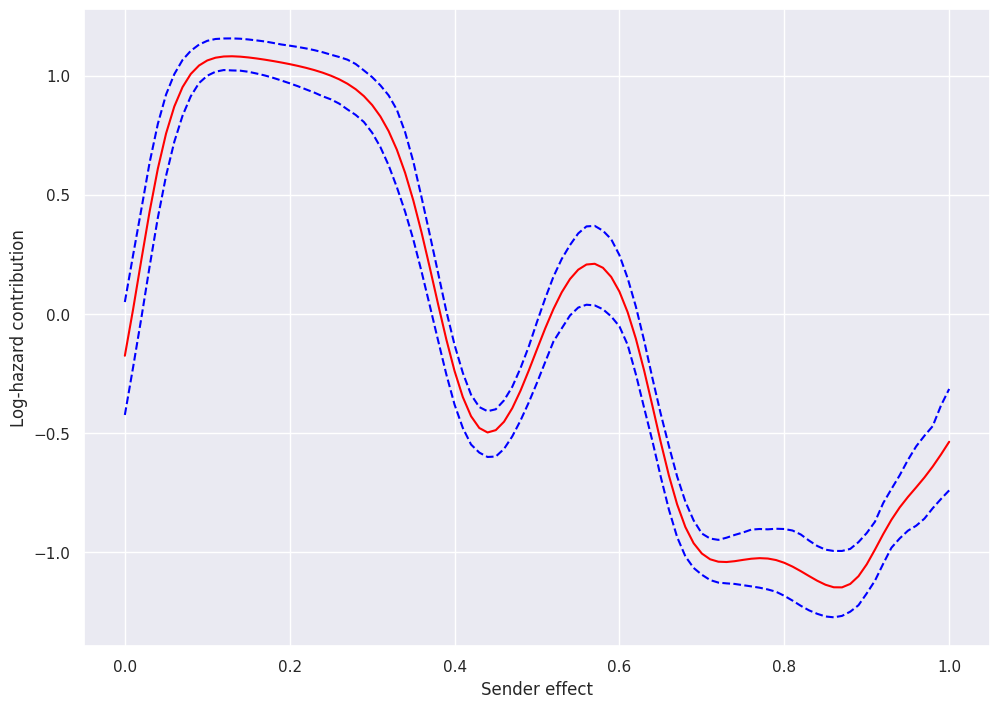

In [12]:
sender_eff = test_sender.mean(dim=0)
sender_eff_lower = test_sender.quantile(q=.025,dim=0)
sender_eff_upper = test_sender.quantile(q=.975,dim=0)


sns.lineplot(x=stat_sender,y=sender_eff,color='red')
sns.lineplot(x=stat_sender,y=sender_eff_lower,color='blue',linestyle='--')
sns.lineplot(x=stat_sender,y=sender_eff_upper,color='blue',linestyle='--')
plt.xlabel('Sender effect')
plt.ylabel('Log-hazard contribution')
plt.show()

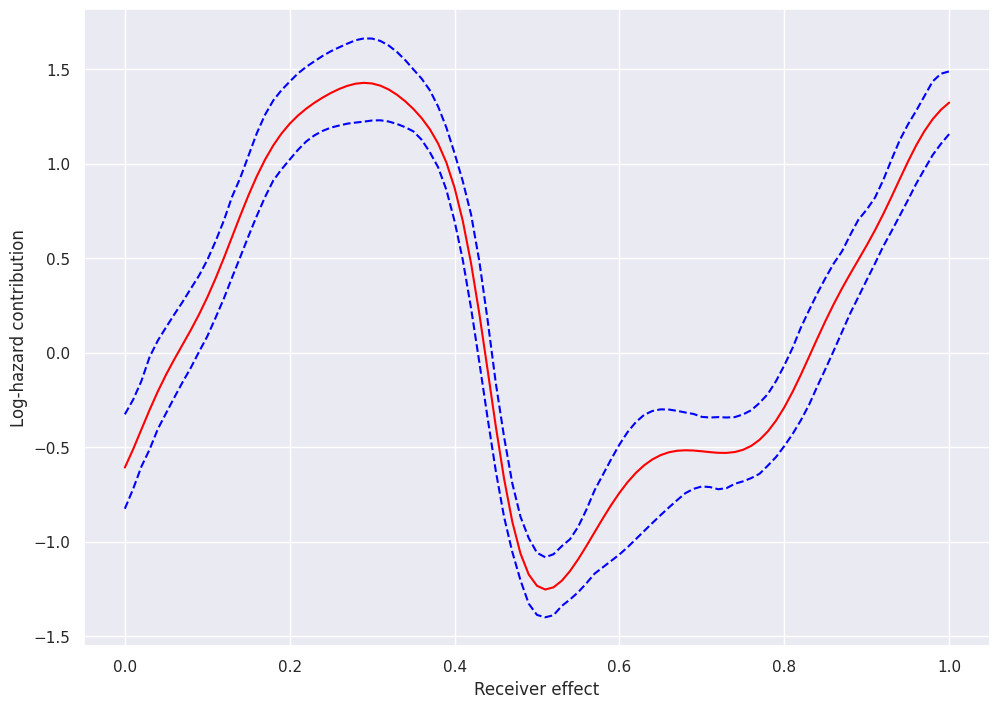

In [13]:
receiver_eff = test_receiver.mean(dim=0)
receiver_eff_lower = test_receiver.quantile(q=.025,dim=0)
receiver_eff_upper = test_receiver.quantile(q=.975,dim=0)


sns.lineplot(x=stat_receiver,y=receiver_eff,color='red')
sns.lineplot(x=stat_receiver,y=receiver_eff_lower,color='blue',linestyle='--')
sns.lineplot(x=stat_receiver,y=receiver_eff_upper,color='blue',linestyle='--')
plt.xlabel('Receiver effect')
plt.ylabel('Log-hazard contribution')
plt.show()

# Gaussian process

A second approach for estimating uncertainty bands involves training a smaller number of models on bootstrap resamples and then fitting a Gaussian process regression. Specifically, we estimate only 5 models on 5 different bootstrap resamples. The retraining of these models is conducted using the train_repetitions function, which is currently still under development.

In [14]:
repetitions = 5
models = tuple(DREAM(2,[512]*2,[1024,512,256,128],dropout=0.0,feature_dropout=0.0) for _ in range(repetitions))

In [15]:
stat_test_original = torch.column_stack((stat_sender,stat_receiver))

stat_test = (stat_test_original-ev_mean)/ev_std

We will run now the multiple fits.

In [16]:
DREAM_gp_5 = DREAM_gp(models=models)
DREAM_gp_5.train_repetitions(x_event=x_event,
                        x_non_event=x_non_event,
                        stat_test=stat_test,
                        repetitions=repetitions,
                        batch_size=2**12,
                        model_verbose=False,
                        gradient_clipping=1.0)

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


After having trained the 5 different neural networks, we can now estimate the predicted effects with the connected uncertainty using the Gaussian Process approach. 

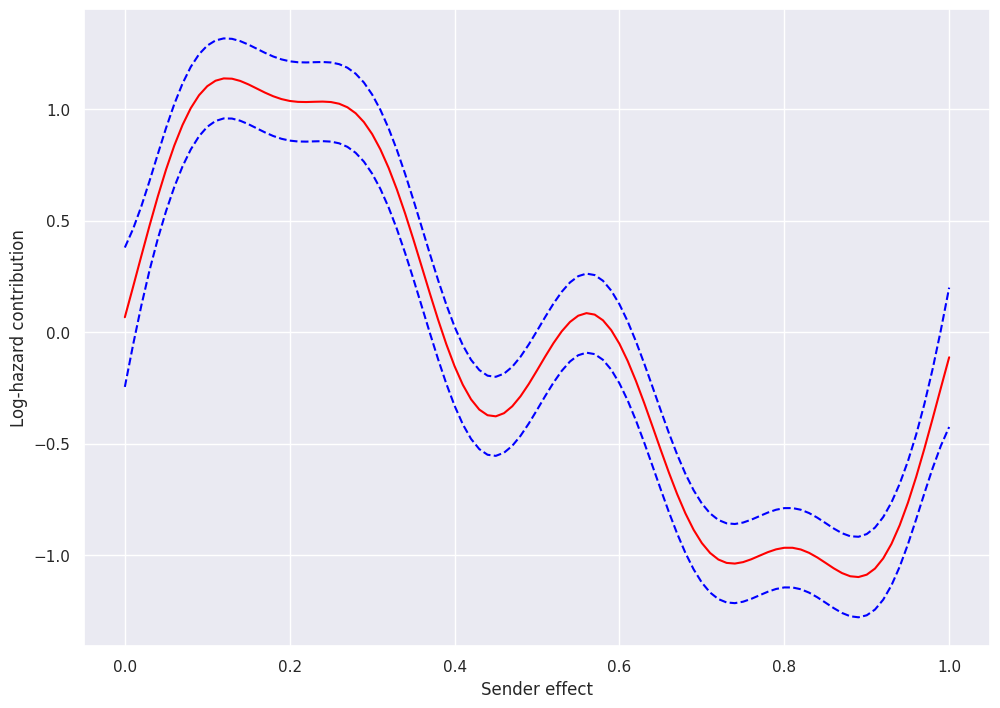

In [17]:
m,s = DREAM_gp_5.gp_feature(0)

sns.lineplot(x=stat_receiver,y=m,color='red')
sns.lineplot(x=stat_receiver,y=m+2*s,color='blue',linestyle='--')
sns.lineplot(x=stat_receiver,y=m-2*s,color='blue',linestyle='--')
plt.xlabel('Sender effect')
plt.ylabel('Log-hazard contribution')
plt.show()

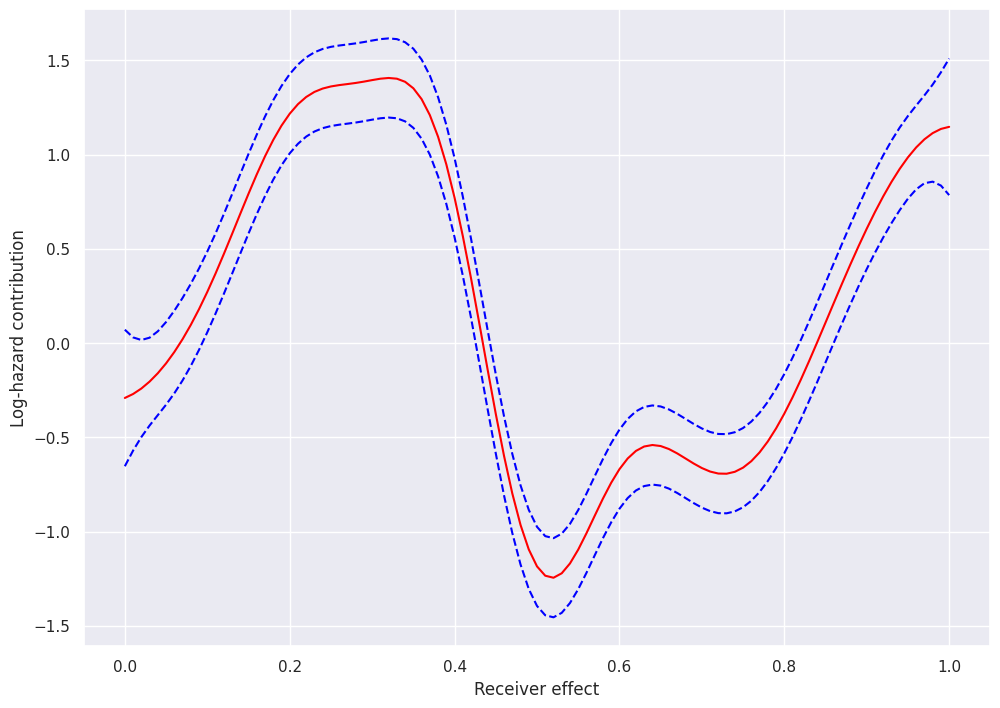

In [18]:
m,s = DREAM_gp_5.gp_feature(1)

sns.lineplot(x=stat_sender,y=m,color='red')
sns.lineplot(x=stat_sender,y=m+2*s,color='blue',linestyle='--')
sns.lineplot(x=stat_sender,y=m-2*s,color='blue',linestyle='--')
plt.xlabel('Receiver effect')
plt.ylabel('Log-hazard contribution')
plt.show()